## Time Series Prediction with Feedforward NN vs RNN (LSTM/GRU)


### 1. Import Libraries

In [3]:
!pip install yfinance


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout


### 2.Load Data

C:\Users\bbuser\AppData\Local\Temp\ipykernel_15476\1565278904.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


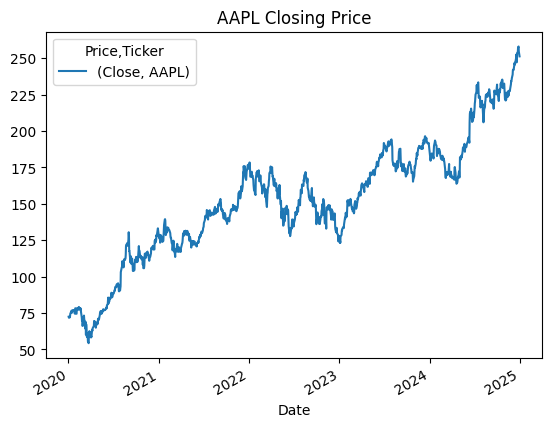

In [5]:
data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
data = data[['Close']]  # Use closing price
data.plot(title="AAPL Closing Price")
plt.show()


### 3. Scale Data

In [6]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


### 4. Create Lagged Features for Feedforward NN

In [8]:
def create_lagged_features(series, window_size):
    X, y = [], []
    for i in range(window_size, len(series)):
        X.append(series[i-window_size:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

window_size = 10  # You can tune this
X_ff, y_ff = create_lagged_features(scaled_data, window_size)

# Split into train/test
split = int(0.8 * len(X_ff))
X_train_ff, X_test_ff = X_ff[:split], X_ff[split:]
y_train_ff, y_test_ff = y_ff[:split], y_ff[split:]


### 5. Feedforward NN

In [9]:
model_ff = Sequential([
    Dense(64, activation='relu', input_shape=(window_size,)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_ff.compile(optimizer='adam', loss='mae')
model_ff.fit(X_train_ff, y_train_ff, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

y_pred_ff = model_ff.predict(X_test_ff)
mae_ff = mean_absolute_error(y_test_ff, y_pred_ff)
print("Feedforward NN MAE:", mae_ff)


Epoch 1/50


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0849 - val_loss: 0.0232
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - val_loss: 0.0195
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - val_loss: 0.0169
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0168 - val_loss: 0.0154
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0157 - val_loss: 0.0120
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0190
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0150 - val_loss: 0.0125
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0134 - val_loss: 0.0120
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - val_loss: 0.0298
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0149 - val_loss: 0.0204
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0135 - val_loss: 0.0205


### 6. Prepare Data for LSTM/GRU

In [11]:
def create_sequences(series, seq_length):
    X, y = [], []
    for i in range(seq_length, len(series)):
        X.append(series[i-seq_length:i, 0])
        y.append(series[i, 0])
    return np.array(X), np.array(y)

seq_length = 10
X_seq, y_seq = create_sequences(scaled_data, seq_length)

X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

# Reshape for RNN input [samples, timesteps, features]
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], 1))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], 1))


### 7. LSTM Model

In [15]:
model_lstm = Sequential([
    LSTM(50, activation='tanh', return_sequences=False, input_shape=(seq_length,1)),
    Dropout(0.2),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mae')
model_lstm.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

y_pred_lstm = model_lstm.predict(X_test_seq)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
print("LSTM MAE:", mae_lstm)


Epoch 1/50


C:\Users\bbuser\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0777 - val_loss: 0.0184
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0356 - val_loss: 0.0194
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0342 - val_loss: 0.0194
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0315 - val_loss: 0.0180
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0309 - val_loss: 0.0169
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286 - val_loss: 0.0351
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0286 - val_loss: 0.0298
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0283 - val_loss: 0.0298
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.0157
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0283 - val_loss: 0.0361
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.0315
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.0150


### 8. Observations

In [14]:
print("Feedforward NN MAE:", mae_ff)
print("LSTM MAE:", mae_lstm)


Feedforward NN MAE: 0.03749886377869292
LSTM MAE: 0.019400296847506347


***Lower MAE indicates better predictive performance.***

***Usually, RNNs (LSTM/GRU) perform better than a simple feedforward network on time series because they remember temporal patterns.***

***2. Visual Comparison of Predictions***

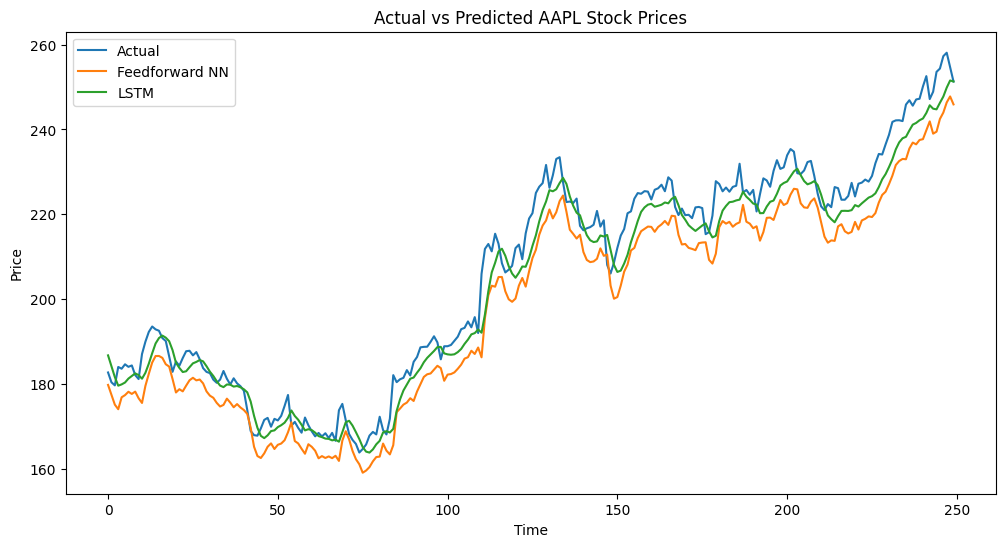

In [18]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_ff_inv, label='Feedforward NN')
plt.plot(y_pred_lstm_inv, label='LSTM')
plt.title('Actual vs Predicted AAPL Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


***RNN predictions generally follow trends and peaks more smoothly than feedforward NN.***

***Feedforward NN may lag behind or miss subtle temporal dependencies.***